In [1]:
%load_ext autoreload
%autoreload 2
    
import helper_methods_for_aggregate_data_analysis as helper
import covid_constants_and_util as cu
from dataset import *
from poisson_reg_model import *
from results import *

import metis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import time 
import pandas as pd
import geopandas as gpd
import torch as t
from collections import Counter
import copy
from scipy.stats import pearsonr, linregress
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
import datetime 

Setting numpy cores to 1
Running code on rambo.stanford.edu; at Stanford=True


/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Importing plotly failed. Interactive plots will not work.


In [2]:
# dset is used throughout the analyses
ca_dir = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA')
county_data_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/county_dynamic_attrs_2021_t1t2.pkl')
dset = CBGPOIDataset(directory=ca_dir, start_date='2021-02-01', end_date='2021-03-29', 
                     path_to_county_data=county_data_fn, cbg_count_min=50, poi_count_min=30,
                     load_distances_dynamically=True)
adj_dict = helper.load_county_adjacency_dict()  # load adjacency matrix for counties
device = t.device('cpu')

Loading /dfs/project/safegraph-homes/all_aggregate_data/raw_safegraph_data/open_census_data/safegraph_open_census_data/metadata/cbg_field_descriptions.csv


/dfs/scratch0/serinac/covid_spillovers_aaai23/helper_methods_for_aggregate_data_analysis.py:1348: RuntimeWarning: invalid value encountered in true_divide
  new_df[group] = np.sum(df[cols].values, axis=1) / totals


Loaded data from /dfs/project/safegraph-homes/all_aggregate_data/cbg_poi_data/CA
Keeping data for 9 weeks, from 2021-02-01 to 2021-03-29
Keeping 22972/23212 CBGs with at least 50 nonzero visits
Keeping 128655/614847 POIs with at least 30 nonzero visits
Keeping 9/9 ACS fields that are estimate, not margin of error, and cover at least 90% of CBGs.
Filling remaining NaN entries (0.356% of all entries) with medians.
480 POIs (0.37%) are missing sub_category
106 POIs (0.08%) are missing top_category
Found 1 values <= 0 in CBG device counts -> clipping to 2
Applying min-max scaling to CBG and POI attributes (besides POI categories).
Loaded dynamic county data from /dfs/project/safegraph-homes/all_aggregate_data/cbg_poi_data/CA/county_dynamic_attrs_2021_t1t2.pkl
Modeling 176 subcategories and 25 POI groups


# Figure 1. Data

In [3]:
# load tiers data 
directory = os.path.join(cu.BASE_DIR, 'external_datasets_for_aggregate_analysis/blueprints_cdph')
fns = sorted(os.listdir(directory))
results_df = []
for fn in fns:
    mapping = {'date': ['date of tier assessment', 'date of tier assignment'],
               'tier': ['final tier', 'updated tier assignment', 'updated overall tier status',
                        'tier assignment 9/15'] }
    cols = {k:None for k in mapping}
    header = 0
    while cols['date'] is None and cols['tier'] is None and header <= 10:
        df = pd.read_excel(os.path.join(directory, fn), header=header)
        df = df.iloc[:58]  # already in alphabetical order of counties
        for orig_col in df.columns:
            if type(orig_col) == str:
                for k, possibilities in mapping.items():
                    for v in possibilities:
                        if v in orig_col.lower():
                            cols[k] = orig_col
        header += 1
#     print(header-1, fn, cols['date'], '+', cols['tier'])
    if cols['tier'] is None:
        print('Couldn\'t find tier column, skipping', fn)
    else:
        if cols['date'] is None:
            print(fn, 'getting date from filename')
            ds = (fn.split('.')[0]).split('_')[-1]
            dt = datetime.datetime.strptime(ds, '%m%d%y')
            ds = dt.strftime('%Y-%m-%d')
        else:
            dates = df[cols['date']].values
            assert all(dates[0] == dates)  # should all be the same date
            ds = pd.to_datetime(dates[0]).strftime('%Y-%m-%d')
        results = {'date':ds}
        for i, tier in enumerate(df[cols['tier']].values):
            results[i] = tier
        if len(results) != 59:
            print(fn, len(results))
        results_df.append(results)
columns = list(results_df[-1].keys())
results_df = pd.DataFrame(results_df, columns=columns).sort_values(by='date')
tier_datetimes = [datetime.datetime.strptime(s, '%Y-%m-%d') for s in results_df.date.values]

/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Couldn't find tier column, skipping Blueprint_Data_Chart_083120.xlsx
Blueprint_Data_Chart_111620.xlsx getting date from filename
Blueprint_Data_Chart_112420.xlsx getting date from filename
Blueprint_Data_Chart_112820.xlsx getting date from filename
Blueprint_Data_Chart_120120.xlsx getting date from filename


In [4]:
# load mobility data
with open(os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/visits.pkl'), 'rb') as f:
    visits = pickle.load(f)
print(len(visits))
with open(os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/index.pkl'), 'rb') as f:
    indices = pickle.load(f)
assert len(visits) == len(indices['weeks'])
print(indices['weeks'][-1])  # last week

121
2021-04-19


In [5]:
# find intersection of time periods
tier_datetimes = np.array([datetime.datetime.strptime(s, '%Y-%m-%d') for s in results_df.date.values])
mobility_datetimes = np.array([datetime.datetime.strptime(s, '%Y-%m-%d') for s in indices['weeks']])
min_intersect = max(tier_datetimes[0], mobility_datetimes[0])
max_intersect = min(tier_datetimes[-1], mobility_datetimes[-1])
print(min_intersect, max_intersect)

2020-09-08 00:00:00 2021-04-19 00:00:00


## Figure 1a. Tiers over time 

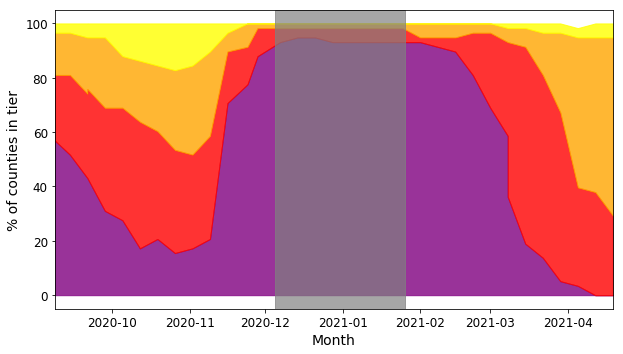

In [6]:
within_range = (tier_datetimes >= min_intersect) & (tier_datetimes <= max_intersect)
kept_datetimes = tier_datetimes[within_range]
tier_mat = results_df.values[within_range, 1:]  # skip date column

fig, ax = plt.subplots(figsize=(10, 5.5))
base = np.zeros(len(kept_datetimes))
for tier in [1, 2, 3, 4]:
    prop_in_tier = 100. * np.sum(tier_mat == tier, axis=1) / 58
    ax.fill_between(kept_datetimes, base, base+prop_in_tier, linestyle='-', color=cu.TIER2COLOR[tier], alpha=0.8)
    base = base + prop_in_tier
ax.axvspan(datetime.datetime(2020, 12, 5), datetime.datetime(2021, 1, 26), alpha=0.7, color='grey')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_intersect, max_intersect)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('% of counties in tier', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('./figs/fig1a.pdf', bbox_inches='tight')

## Figure 1b. County map of tiers

In [7]:
# 9-week period that we study, including 2 for 3/08/21
week_index = list(kept_datetimes).index(datetime.datetime(2021, 2, 1))
for i in range(week_index, week_index+10):
    tiers = tier_mat[i]
    print(i, kept_datetimes[i], Counter(tiers))

23 2021-02-01 00:00:00 Counter({1.0: 54, 3.0: 3, 2.0: 1})
24 2021-02-08 00:00:00 Counter({1.0: 53, 3.0: 3, 2.0: 2})
25 2021-02-15 00:00:00 Counter({1.0: 52, 3.0: 3, 2.0: 3})
26 2021-02-22 00:00:00 Counter({1.0: 47, 2.0: 9, 3.0: 2})
27 2021-03-01 00:00:00 Counter({1.0: 40, 2.0: 16, 3.0: 2})
28 2021-03-08 00:00:00 Counter({1.0: 34, 2.0: 20, 3.0: 3, 4.0: 1})
29 2021-03-08 00:00:00 Counter({2.0: 33, 1.0: 21, 3.0: 3, 4.0: 1})
30 2021-03-15 00:00:00 Counter({2.0: 42, 1.0: 11, 3.0: 4, 4.0: 1})
31 2021-03-22 00:00:00 Counter({2.0: 39, 3.0: 9, 1.0: 8, 4.0: 2})
32 2021-03-29 00:00:00 Counter({2.0: 36, 3.0: 17, 1.0: 3, 4.0: 2})


In [8]:
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
ca_geom = geoData[geoData['STATE'] == '06'].sort_values(by='id')
ca_geom.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
2248,06001,0500000US06001,06,001,Alameda,County,739.017,"POLYGON ((-121.85576 37.48454, -122.04527 37.4..."
684,06003,0500000US06003,06,003,Alpine,County,738.332,"POLYGON ((-120.07239 38.70277, -119.88030 38.8..."
23,06005,0500000US06005,06,005,Amador,County,594.583,"POLYGON ((-120.99550 38.22541, -121.02708 38.3..."
685,06007,0500000US06007,06,007,Butte,County,1636.464,"POLYGON ((-121.07670 39.59726, -121.14991 39.5..."
740,06009,0500000US06009,06,009,Calaveras,County,1020.012,"POLYGON ((-120.65267 37.83142, -120.92645 38.0..."


Counter({'red': 42, 'purple': 11, 'orange': 4, 'yellow': 1})


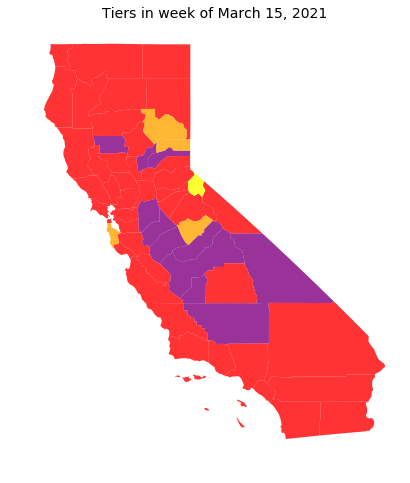

In [16]:
week_index = list(kept_datetimes).index(datetime.datetime(2021, 3, 15))
colors = [cu.TIER2COLOR[t] for t in tier_mat[week_index]]
print(Counter(colors))
fig, ax = plt.subplots(figsize=(8, 8))
ca_geom.plot(color=colors, ax=ax, alpha=0.8)
ax.set_title('Tiers in week of March 15, 2021', fontsize=14)
ax.set_axis_off()  # remove axes
plt.savefig('./figs/fig1b.pdf', bbox_inches='tight')

## Figure 1c. Mobility over time

In [10]:
within_range = (mobility_datetimes >= min_intersect) & (mobility_datetimes <= max_intersect)
kept_datetimes = mobility_datetimes[within_range]
kept_date_strs = indices['weeks'][within_range]

In [11]:
cbg_device_counts = pd.read_csv(os.path.join(cu.PATH_TO_CBG_POI_DATA, 'cbg_device_counts.csv')).set_index('census_block_group')
cbg_device_counts = cbg_device_counts.loc[indices['cbgs']][kept_date_strs]
cbg_device_counts.shape

(23212, 32)

/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


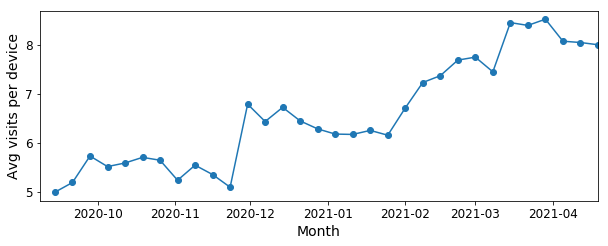

In [12]:
total_visits = np.array([m.sum() for m in visits])[within_range]
total_devices = np.sum(cbg_device_counts, axis=0)
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot_date(kept_datetimes, total_visits / total_devices, linestyle='-')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_intersect, max_intersect)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Avg visits per device', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('./figs/fig1c.pdf', bbox_inches='tight')

# Figure 2. Z assignment variable

In [13]:
# load processed county-level dynamic variables
path_to_data = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/county_dynamic_attrs_2021_t1t2.pkl')
with open(path_to_data, 'rb') as f:
    fips, population, tier_dates, blueprint_stages, tiers, assignment_vars = pickle.load(f)
print(tiers.shape, assignment_vars.shape)

(9, 58) (9, 58)


## Figure 2a. Z vs tier

[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  32.  33.  34.  35.  36.  37.  38.  39.  40.]
purple (289,)
0
red (181,)
9


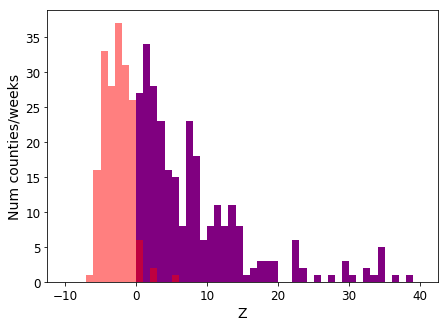

In [14]:
bins = np.linspace(-10, 40, 51)
fig, ax = plt.subplots(figsize=(7,5))
print(bins)

z_vec_t1 = assignment_vars[tiers == 1]
print('purple', z_vec_t1.shape)
print(np.sum(z_vec_t1 < 0))  # non-compliers
ax.hist(z_vec_t1, bins=bins, color='purple')

z_vec_t2 = assignment_vars[tiers == 2]
print('red', z_vec_t2.shape)
print(np.sum(z_vec_t2 >= 0))  # non-compliers
ax.hist(z_vec_t2, bins=bins, color='red', alpha=0.5)

ax.set_xlabel('Z', fontsize=14)
ax.set_ylabel('Num counties/weeks', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('./figs/fig2a.pdf', bbox_inches='tight')

## Figure 2c. Scatter plot

In [15]:
# load saved tensors (n_weeks, n_counties, n_counties) per POI group
# representing total num visits (within group) from county to county in each week
path_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'poi_group2county_county_tensor.pkl')
with open(path_fn, 'rb') as f:
    group2tensor = pickle.load(f)

# load total device count per county and week
path_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'county_device_counts.pkl')
with open(path_fn, 'rb') as f:
    county_device_counts = pickle.load(f)

# num POIs per group
path_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'group2poi_counts.pkl')
with open(path_fn, 'rb') as f:
    group2poi_counts = pickle.load(f)

In [16]:
def get_cross_county_data_points_changing_poi(group=None, min_visits=20, cbg_condition='control', max_z=10):
    if group is None:
        tensor = 0
        for g in group2tensor:
            tensor += group2tensor[g]
    else:
        tensor = group2tensor[group]
    all_z = []
    all_y = []
    for i, cbg_county in enumerate(dset.indices['counties']):
        device_counts = county_device_counts[:, i]
        if cbg_condition == 'control':
            valid_weeks_cbg = (dset.county_tiers[:, i] == 1) & (dset.county_assignment_vars[:, i] <= max_z)  # when cbg county was in purple
        else:
            valid_weeks_cbg = (dset.county_tiers[:, i] == 2) & (dset.county_assignment_vars[:, i] >= -max_z)  # when cbg county was in red
        valid_weeks_cbg[5] = False  # skip week 5
        for j, poi_county in enumerate(dset.indices['counties']):
            cross_county_visits = tensor[:, i, j]
            if i != j and np.mean(cross_county_visits) >= min_visits:
                valid_weeks_poi = np.isin(dset.county_tiers[:, j], [1, 2])  # purple or red tier
                valid_weeks = valid_weeks_cbg & valid_weeks_poi
                if group is None:
                    num_pois_in_group = np.sum([group2poi_counts[g][j] for g in group2poi_counts])
                else:
                    num_pois_in_group = group2poi_counts[group][j]
                normalized_visits = cross_county_visits / (device_counts * num_pois_in_group)
                all_z.append(dset.county_assignment_vars[valid_weeks, j])
                all_y.append(normalized_visits[valid_weeks])
    all_z = np.concatenate(all_z)
    all_y = 1000 * np.concatenate(all_y)
    print('below 0: %d data points; above 0: %d data points' % (np.sum(all_z < 0), np.sum(all_z >= 0)))
    return all_z, all_y

In [17]:
def make_rd_plot(all_z, all_y, ax, plot_polyfit=True, z_order=1, xlim=(-7, 20), interval=0.5):    
    z_bins = np.arange(xlim[0], xlim[1]+interval, interval)
    bins_kept = []
    avg_y = []
    size = []
    for bin_start in z_bins:  # plot average outcome per bin
        y_in_bin = all_y[(all_z >= bin_start) & (all_z < (bin_start+interval))]
        if len(y_in_bin) >= 3:
            avg_y.append(np.mean(y_in_bin))
            bins_kept.append(bin_start)
            size.append(len(y_in_bin))
    scaling = 200 / np.mean(size) 
    ax.scatter(np.array(bins_kept)+(interval/2), avg_y, s=np.array(size)*scaling, alpha=0.5)
        
    if plot_polyfit:
        # plot fit to the left of the cutoff
        z0 = all_z[all_z < 0]
        y0 = all_y[all_z < 0]
        p = np.poly1d(np.polyfit(z0, y0, z_order))
        reg_x = np.linspace(np.min(all_z), 0, 100)
        ax.plot(reg_x, p(reg_x), color='black')
        # plot fit to the right of the cutoff
        z1 = all_z[(all_z >= 0) & (all_z <= xlim[1])]
        y1 = all_y[(all_z >= 0) & (all_z <= xlim[1])]
        p = np.poly1d(np.polyfit(z1, y1, z_order))
        reg_x = np.linspace(0, xlim[1], 100)
        ax.plot(reg_x, p(reg_x), color='black')
        
    ax.set_xlabel('Z', fontsize=14)
    ax.set_ylabel('Avg visits per device & POI (per 1000)', fontsize=14)
    ax.set_xlim(xlim)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ymin, ymax = plt.ylim()
    ax.vlines([0], ymin, ymax)

below 0: 916 data points; above 0: 3269 data points


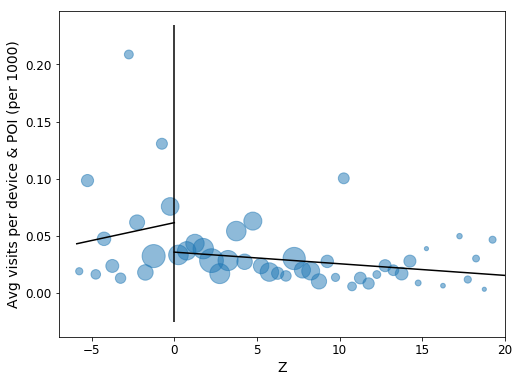

In [18]:
all_z, all_y = get_cross_county_data_points_changing_poi(None, min_visits=10, cbg_condition='control', max_z=5)
fig, ax = plt.subplots(figsize=(8, 6))
make_rd_plot(all_z, all_y, ax, z_order=1, xlim=(-7, 20), interval=0.5)
plt.savefig('./figs/fig2c.pdf', bbox_inches='tight')

# Figure 3. Spillovers

{'Other': 0, 'Automobile Dealers': 1, 'Automotive Parts, Accessories, and Tire Stores': 2, 'Building Material and Supplies Dealers': 3, 'Clothing Stores': 4, 'Department Stores': 5, 'Drinking Places (Alcoholic Beverages)': 6, 'Elementary and Secondary Schools': 7, 'Gasoline Stations': 8, 'General Merchandise Stores, including Warehouse Clubs and Supercenters': 9, 'Grocery Stores': 10, 'Health and Personal Care Stores': 11, 'Lessors of Real Estate': 12, 'Museums, Historical Sites, and Similar Institutions': 13, 'Office Supplies, Stationery, and Gift Stores': 14, 'Other Amusement and Recreation Industries': 15, 'Other Miscellaneous Store Retailers': 16, 'Religious Organizations': 17, 'Sporting Goods, Hobby, and Musical Instrument Stores': 18, 'Traveler Accommodation': 19, 'Used Merchandise Stores': 20, 'Full-Service Restaurants': 21, 'Snack and Nonalcoholic Beverage Bars': 22, 'Limited-Service Restaurants': 23, 'Fitness and Recreational Sports Centers': 24}
a=0.050 (using Bonferroni=Fals

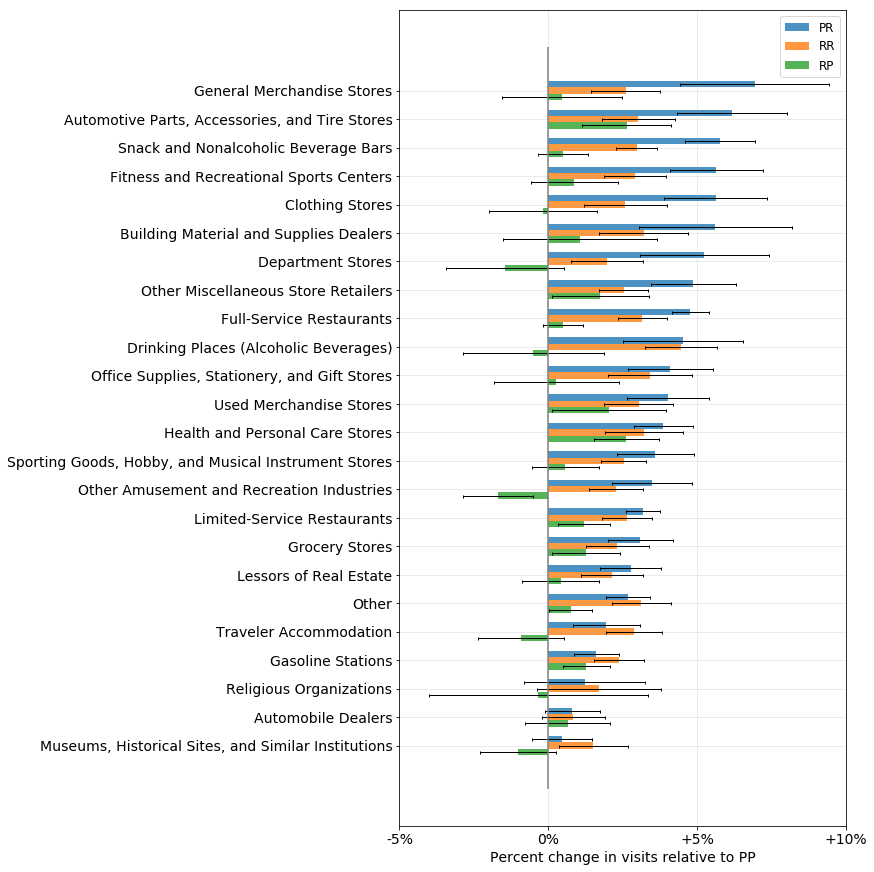

In [19]:
main_exts = get_main_experiment_names()
group2idx = {g:i for i,g in enumerate(dset.poi_group_labels)}
print(group2idx)
del group2idx['Elementary and Secondary Schools']  # poor coverage
h5_df = summarize_tier_pair_weights_over_multiple_models(main_exts, device, group2idx)
plot_tier_pair_weights(h5_df, [(0, 1), (1, 1), (1, 0)], sort_col='0->1 mean', xlim=(-0.05, .1), labels=['PR', 'RR', 'RP'])
plt.savefig('./figs/fig3.pdf', bbox_inches='tight')

a=0.002 (using Bonferroni=True) -> zscore=3.078
0->1: 21 above, 0 below
1->1: 21 above, 0 below
1->0: 3 above, 0 below


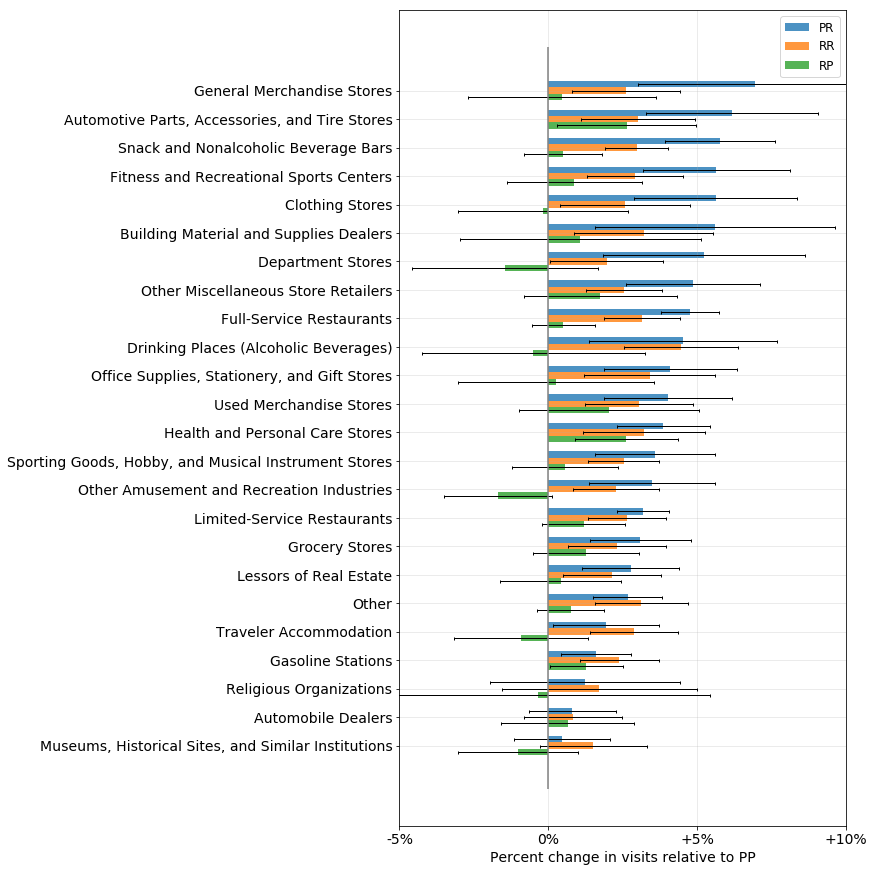

In [20]:
# with Bonferroni correction
plot_tier_pair_weights(h5_df, [(0, 1), (1, 1), (1, 0)], sort_col='0->1 mean', xlim=(-0.05, .1), labels=['PR', 'RR', 'RP'],
                       use_bonferroni=True)

# County-level, macro-county, and statewide analysis 

In [10]:
# local vs global
print('All counties')
out = summarize_percent_reduction_over_experiments(dset, device)
print('Small counties')
out = summarize_percent_reduction_over_experiments(dset, device, county_type='small')
print('Large counties')
out = summarize_percent_reduction_over_experiments(dset, device, county_type='large')

All counties
0.540 (0.464-0.617)
Small counties
Computing mean percent of mobility reduction kept over 23 counties
0.417 (0.310-0.524)
Large counties
Computing mean percent of mobility reduction kept over 35 counties
0.621 (0.563-0.679)


In [11]:
# compare to macrocounty - ACTUAL
# construct true county2macrocounty from Regional Stay-At-Home
# https://www.gov.ca.gov/2020/12/03/california-health-officials-announce-a-regional-stay-at-home-order-triggered-by-icu-capacity/
reg1 = "Northern California: Del Norte, Glenn, Humboldt, Lake, Lassen, Mendocino, Modoc, Shasta, Siskiyou, Tehama, Trinity"
reg2 = "Bay Area: Alameda, Contra Costa, Marin, Monterey, Napa, San Francisco, San Mateo, Santa Clara, Santa Cruz, Solano, Sonoma"
reg3 = "Greater Sacramento: Alpine, Amador, Butte, Colusa, El Dorado, Nevada, Placer, Plumas, Sacramento, Sierra, Sutter, Yolo, Yuba"
reg4 = "San Joaquin Valley: Calaveras, Fresno, Kern, Kings, Madera, Mariposa, Merced, San Benito, San Joaquin, Stanislaus, Tulare, Tuolumne"
reg5 = "Southern California: Imperial, Inyo, Los Angeles, Mono, Orange, Riverside, San Bernardino, San Diego, San Luis Obispo, Santa Barbara, Ventura"

name2fips = helper.load_county_name_to_fips()
actual_county2macrocounty = {}
reg_names = []
for reg, reg_str in enumerate([reg1, reg2, reg3, reg4, reg5]):
    reg_name, counties = reg_str.split(': ', 1) 
    reg_names.append(reg_name)
    counties = counties.split(', ')
    print(reg_name, len(counties))
    for c in counties:
        full_name = '%s County, CA' % c
        if full_name in name2fips:
            actual_county2macrocounty[name2fips[full_name]] = reg
        else:
            print('Could not find %s in name2fips' % full_name)
out = summarize_percent_reduction_over_experiments(dset, device, county2macrocounty=actual_county2macrocounty)

Northern California 11
Bay Area 11
Greater Sacramento 13
San Joaquin Valley 12
Southern California 11
0.921 (0.909-0.933)


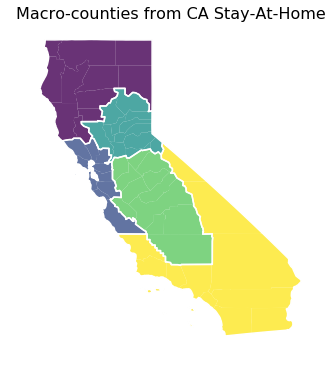

In [12]:
# visualize actual macrocounties
ax = visualize_partition(actual_county2macrocounty)
ax.set_title('Macro-counties from CA Stay-At-Home', fontsize=16)
plt.savefig('./figs/fig4a.pdf', bbox_inches='tight')

In [5]:
# compare to macrocounty - RANDOM
counties = sorted(list(dset.county2idx.keys()))
macrocounty_assignments = np.concatenate([np.arange(5) for i in range(12)])[:58]
num_random_assignments = 10
np.random.seed(0)
all_prs = []
for i in range(num_random_assignments):
    print('Assignment', i)
    np.random.shuffle(macrocounty_assignments)
    county2macrocounty = {c:m for c,m in zip(counties, macrocounty_assignments)}
    prs = summarize_percent_reduction_over_experiments(dset, device, county2macrocounty=county2macrocounty)
    all_prs.append(prs)
all_prs = np.concatenate(all_prs)
assert len(all_prs) == (30 * num_random_assignments)  # num_experiments x num_random_assignments
mean_of_means = np.mean(all_prs)
se = np.std(all_prs, ddof=1)
zscore = 1.96
print('OVERALL: %.3f (%.3f-%.3f)' % (mean_of_means, mean_of_means - (zscore * se), mean_of_means + (zscore * se)))

Assignment 0
0.639 (0.578-0.699)
Assignment 1
0.687 (0.636-0.739)
Assignment 2
0.632 (0.572-0.693)
Assignment 3
0.618 (0.554-0.681)
Assignment 4
0.621 (0.559-0.684)
Assignment 5
0.595 (0.528-0.662)
Assignment 6
0.590 (0.521-0.659)
Assignment 7
0.616 (0.553-0.680)
Assignment 8
0.606 (0.540-0.671)
Assignment 9
0.631 (0.570-0.692)
OVERALL: 0.623 (0.543-0.704)


In [6]:
# compare to actual tiers
num_counties_in_purple = []
mean_pr = []
for i in range(dset.num_weeks()):
    tiers = dset.county_tiers[i]
    print('Week %d (%s):' % (i, dset.indices['weeks'][i]), Counter(tiers))
    actual_tiers = (tiers > 1).astype(int)
    num_counties_in_purple.append(np.sum(actual_tiers == 0))
    all_prs = summarize_percent_reduction_over_experiments(dset, device, actual_tiers=actual_tiers)
    mean_pr.append(np.mean(all_prs))

Week 0 (2021-02-01): Counter({1.0: 54, 3.0: 3, 2.0: 1})
Computing mean percent of mobility reduction kept over 54 counties
0.999 (0.999-1.000)
Week 1 (2021-02-08): Counter({1.0: 53, 3.0: 3, 2.0: 2})
Computing mean percent of mobility reduction kept over 53 counties
0.999 (0.999-0.999)
Week 2 (2021-02-15): Counter({1.0: 52, 3.0: 3, 2.0: 3})
Computing mean percent of mobility reduction kept over 52 counties
0.999 (0.999-0.999)
Week 3 (2021-02-22): Counter({1.0: 47, 2.0: 9, 3.0: 2})
Computing mean percent of mobility reduction kept over 47 counties
0.970 (0.966-0.975)
Week 4 (2021-03-01): Counter({1.0: 40, 2.0: 16, 3.0: 2})
Computing mean percent of mobility reduction kept over 40 counties
0.937 (0.928-0.947)
Week 5 (2021-03-08): Counter({2.0: 33, 1.0: 21, 3.0: 3, 4.0: 1})
Computing mean percent of mobility reduction kept over 21 counties
0.799 (0.769-0.828)
Week 6 (2021-03-15): Counter({2.0: 42, 1.0: 11, 3.0: 4, 4.0: 1})
Computing mean percent of mobility reduction kept over 11 counties


## Figure 4. Partitions for different k

In [13]:
# get average county and tier pair weights over 30 trials, make undirected county graph
within_county_weights, tier_self_weights = get_within_county_weights()
main_exts = get_main_experiment_names()
avg_county_county_weights = 0
avg_tier_pair_weights = 0
for i, experiment in enumerate(main_exts):
    save_path = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/adj_county_weights/county_county_weights_v%s.pkl' % i)
    with open(save_path, 'rb') as f:
        counties, group_labels, county_county_weights = pickle.load(f)
    avg_county_county_weights += county_county_weights
    model_fn = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'model_weights', experiment)
    state_dict_adj = t.load(model_fn, map_location=device)
    tier_pair_weights = np.exp(state_dict_adj['tier_pair_weights'].detach().numpy())
    avg_tier_pair_weights += tier_pair_weights
avg_county_county_weights /= len(main_exts)
avg_tier_pair_weights /= len(main_exts)
G = make_networkx_graph_for_metis(dset, tier_self_weights, within_county_weights, avg_tier_pair_weights, 
                                  avg_county_county_weights)

In [9]:
ks = [2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30] # approx N/k=2
mean_for_k, lower_for_k, upper_for_k = compute_metis_partition_per_k(dset, device, G, ks)
# add county-level: 0.540 (0.464-0.617)
ks.append(58)
mean_for_k.append(0.540)
lower_for_k.append(0.464)
upper_for_k.append(0.617)

2 Counter({1: 29, 0: 29})
0.967 (0.962-0.973)
3 Counter({1: 21, 2: 19, 0: 18})
0.952 (0.944-0.959)
4 Counter({1: 16, 2: 15, 3: 14, 0: 13})
0.934 (0.923-0.945)
5 Counter({3: 13, 0: 12, 2: 12, 4: 11, 1: 10})
0.934 (0.923-0.945)
6 Counter({4: 10, 1: 10, 0: 10, 3: 10, 5: 9, 2: 9})
0.925 (0.913-0.937)
7 Counter({5: 10, 3: 9, 6: 9, 2: 8, 4: 8, 1: 7, 0: 7})
0.913 (0.899-0.926)
8 Counter({2: 8, 3: 8, 7: 8, 6: 8, 5: 7, 1: 7, 4: 6, 0: 6})
0.895 (0.879-0.912)
10 Counter({7: 6, 2: 6, 8: 6, 3: 6, 9: 6, 1: 6, 4: 6, 5: 6, 0: 5, 6: 5})
0.877 (0.858-0.896)
12 Counter({5: 6, 11: 6, 8: 5, 3: 5, 9: 5, 2: 5, 4: 5, 10: 5, 6: 4, 0: 4, 1: 4, 7: 4})
0.853 (0.830-0.876)
14 Counter({9: 5, 6: 5, 3: 4, 7: 4, 12: 4, 2: 4, 4: 4, 5: 4, 0: 4, 1: 4, 13: 4, 8: 4, 10: 4, 11: 4})
0.822 (0.793-0.850)
17 Counter({13: 4, 16: 4, 6: 4, 5: 4, 7: 4, 15: 4, 11: 4, 12: 3, 1: 3, 0: 3, 14: 3, 2: 3, 4: 3, 9: 3, 10: 3, 8: 3, 3: 3})
0.809 (0.779-0.839)
20 Counter({9: 4, 4: 4, 10: 3, 12: 3, 11: 3, 6: 3, 5: 3, 2: 3, 7: 3, 8: 3, 1: 3, 0: 

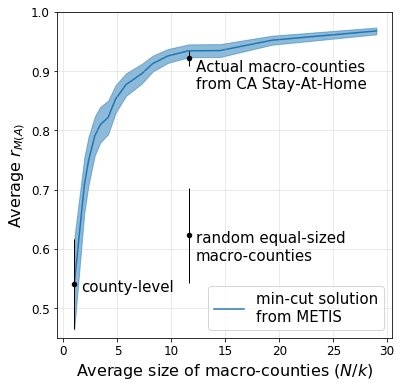

In [35]:
region_sizes = 58 / np.array(ks)
plt.figure(figsize=(6,6))
plt.plot(region_sizes, mean_for_k, color='tab:blue', label='min-cut solution\nfrom METIS', zorder=1)
plt.xlabel(r'Average size of macro-counties ($N/k$)', fontsize=16)
plt.ylabel(r'Average $r_{M(A)}$', fontsize=16)
plt.legend(fontsize=15, loc='lower right')
plt.fill_between(region_sizes, lower_for_k, upper_for_k, color='tab:blue', alpha=0.5, zorder=0)
plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0.45, 1)

x, y = region_sizes[-1], mean_for_k[-1]
plt.scatter([x], [y],  color='black', s=20, zorder=2)
plt.errorbar([x], [y], yerr=y-lower_for_k[-1], color='black', elinewidth=1, zorder=2)
plt.annotate('county-level', (x, y),  fontsize=15, 
             xycoords='data', xytext=(7, -7), textcoords='offset points', zorder=2)

# add CA actual: 0.921 (0.909-0.933)
x, y = 58/5, 0.921
plt.scatter([x], [y], color='black', s=20, zorder=2)
plt.errorbar([x], [y], yerr=0.012, color='black', elinewidth=1, zorder=2)
plt.annotate('Actual macro-counties\nfrom CA Stay-At-Home', (x, y),  fontsize=15,
            xycoords='data', xytext=(7, -30), textcoords='offset points', zorder=2)

# add random: 0.623 (0.543-0.704)
x, y = 58/5, 0.623
plt.scatter([x], [y],  color='black', s=20, zorder=2)
plt.errorbar([x], [y], yerr=0.08, color='black', elinewidth=1, zorder=2)
plt.annotate('random equal-sized\nmacro-counties', (x, y),  fontsize=15,
            xycoords='data', xytext=(7, -25), textcoords='offset points', zorder=2)
plt.savefig('./figs/fig4b.pdf', bbox_inches='tight')

Counter({5: 10, 3: 9, 6: 9, 2: 8, 4: 8, 1: 7, 0: 7})
0.913 (0.899-0.926)


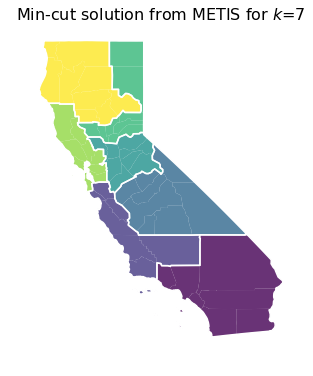

In [14]:
# plot k=7 as an example
cut, parts = metis.part_graph(G, 7, ubvec=[1.05], contig=True, recursive=True)
print(Counter(parts))
county2macrocounty = {}
for ci, p in zip(G.nodes, parts):
    county2macrocounty[dset.indices['counties'][ci]] = p
summarize_percent_reduction_over_experiments(dset, device, county2macrocounty=county2macrocounty)
ax = visualize_partition(county2macrocounty)
ax.set_title(r'Min-cut solution from METIS for $k$=7', fontsize=16)
plt.savefig('./figs/fig4c.pdf', bbox_inches='tight')

# Supplemental figures + checks

## Negative sampling

In [29]:
def plot_distances_from_saved_idxs(fn, ax, title, sample_size=None):
    with open(fn, 'rb') as f:
        idxs = pickle.load(f)
    if 'zero' in fn:
        idxs, _ = idxs
    if sample_size is not None and len(idxs) > sample_size:
        np.random.seed(0)
        sample = np.random.choice(idxs, size=sample_size, replace=False)
        _, c_vec, p_vec = dset.index_to_wcp(sample)
    else:
        _, c_vec, p_vec = dset.index_to_wcp(idxs)
    distances = dset.get_cbg_poi_dists(c_vec, p_vec)
    ax.hist(distances, bins=30, density=True)
    ax.set_title(title)

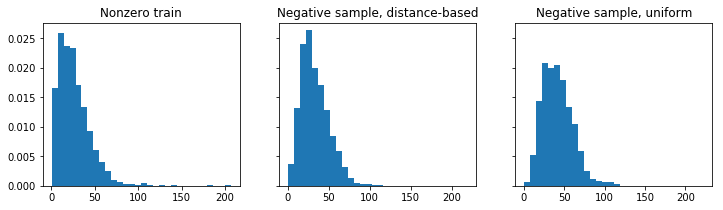

In [30]:
# compare distances in nonzero data points, zero data points sampled based on distance, and
# uniformly sampled zero data points
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
directory = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/sampled_data/t1t2_h5_r02_adj_extended')
week = 1
fn = os.path.join(directory, 'w%d_v0_train_nnz.pkl' % week)
plot_distances_from_saved_idxs(fn, axes[0], 'Nonzero train')
fn = os.path.join(directory, 'w%d_v0_train_zero.pkl' % week)
plot_distances_from_saved_idxs(fn, axes[1], 'Negative sample, distance-based')
directory = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA/sampled_data/t1t2_h5_r02_adj_uniform')
fn = os.path.join(directory, 'w%d_v0_train_zero.pkl' % week)
plot_distances_from_saved_idxs(fn, axes[2], 'Negative sample, uniform')
plt.show()

a=0.050 (using Bonferroni=False) -> zscore=1.960
0->1: 24 above, 0 below
1->1: 24 above, 0 below
1->0: 17 above, 7 below


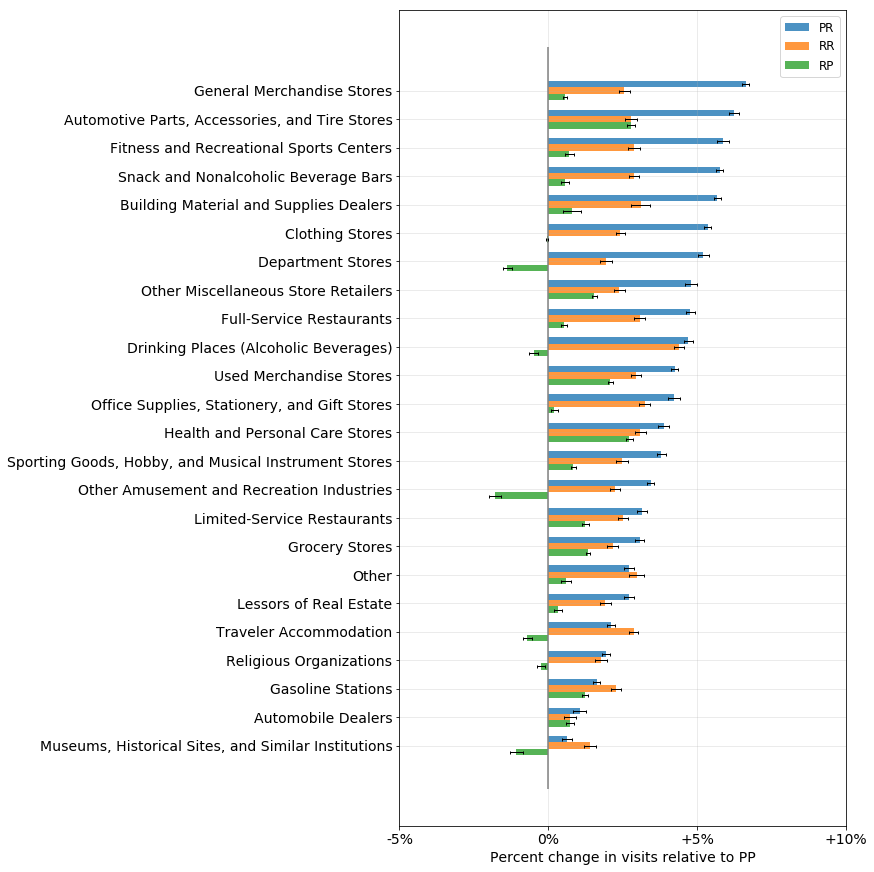

In [32]:
# CIs from only negative sampling and no non-zero sampling
fns = ['neg_sampling_02_v%d_2022_04_27_13_18_13' % v for v in range(10)]
neg02_df = summarize_tier_pair_weights_over_multiple_models(fns, device, group2idx)
plot_tier_pair_weights(neg02_df, [(0, 1), (1, 1), (1, 0)], sort_col='0->1 mean', xlim=(-0.05, .1), labels=['PR', 'RR', 'RP'])
plt.savefig('./figs/neg_sample_cis.pdf', bbox_inches='tight')


## Bandwidth selection

In [33]:
data_name = 't1t2_h5_r02_adj'
directory = os.path.join(cu.PATH_TO_CBG_POI_DATA, 'CA', 'sampled_data', data_name)
get_county_pair_counts_per_tier_pair_type(dset, directory)

Total num nonzero: 684604
CBG tier: 1. POI tier: 1. Total nonzero data points: 289199. Num unique county pairs: 126.
6067 6061 21969 7.596499296332284
6037 6059 16643 5.7548608397677725
6013 6001 14783 5.111705088883433
6059 6037 11477 3.9685476090857854
6061 6067 10762 3.721313005923257

CBG tier: 1. POI tier: 2. Total nonzero data points: 48608. Num unique county pairs: 71.
6077 6067 4323 8.893597761685319
6067 6113 4046 8.323732718894009
6075 6081 3133 6.4454410796576695
6029 6037 2891 5.94758064516129
6115 6101 2863 5.889976958525345

CBG tier: 2. POI tier: 1. Total nonzero data points: 37243. Num unique county pairs: 74.
6067 6077 3892 10.450285959777677
6113 6067 3097 8.315656633461321
6017 6067 3004 8.065945278307334
6107 6019 2782 7.469860107939747
6081 6075 1977 5.308380098273501

CBG tier: 2. POI tier: 2. Total nonzero data points: 309554. Num unique county pairs: 177.
6067 6061 23656 7.641962307061126
6065 6071 23291 7.524050731051771
6037 6059 18607 6.010906013167331
6071 6

/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/numpy/core/_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


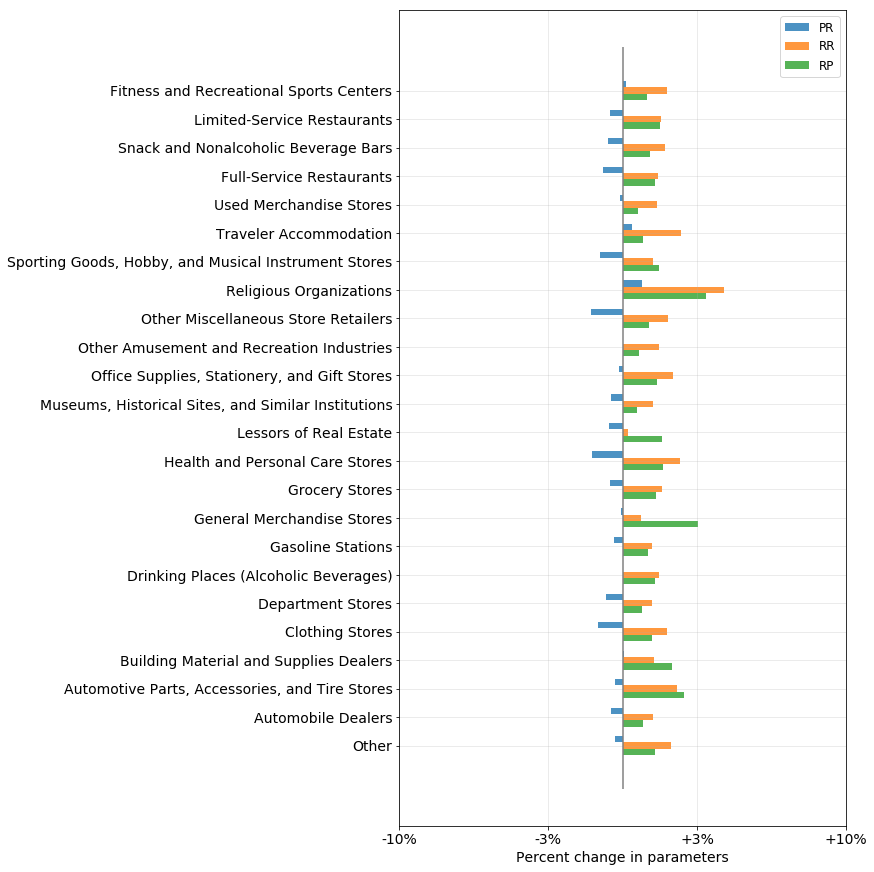

In [34]:
# comparison of h=4 and h=5
h4_df = summarize_tier_pair_weights_over_multiple_models(['test_poireg_t1t2_h4_adj_2022_04_19_11_50_32'], device, group2idx)
plot_percent_change_in_weights(h4_df, h5_df, [(0, 1), (1, 1), (1, 0)], xlim=(-0.1, 0.1), labels=['PR', 'RR', 'RP'])
plt.savefig('./figs/h4_v_h5.pdf', bbox_inches='tight')


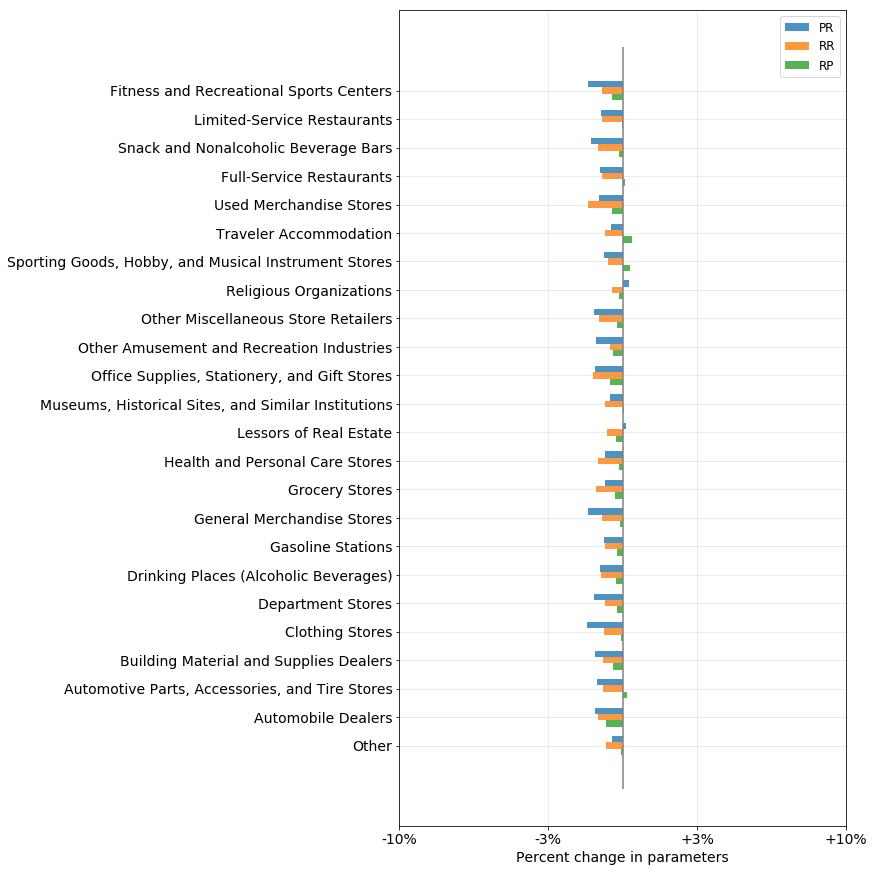

In [35]:
# comparison of h=6 and h=5
h6_df = summarize_tier_pair_weights_over_multiple_models(['test_poireg_t1t2_h6_adj_2022_04_19_11_54_53'], device, group2idx)
plot_percent_change_in_weights(h6_df, h5_df, [(0, 1), (1, 1), (1, 0)], xlim=(-0.1, 0.1), labels=['PR', 'RR', 'RP'])
plt.savefig('./figs/h6_v_h5.pdf', bbox_inches='tight')


## Model fitting

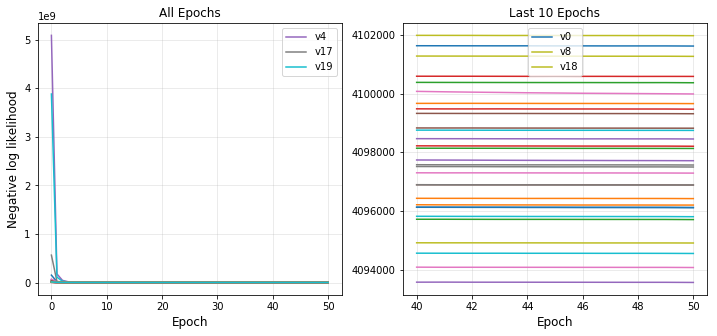

In [36]:
# losses over epochs
labels = [f'v{v}' for v in range(len(main_exts))]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax = axes[0]
ax.set_title('All Epochs')
plot_loss_over_epochs(main_exts, labels, ax=ax, skip_n=0, label_axes=True)
ax = axes[1]
ax.set_title('Last 10 Epochs')
plot_loss_over_epochs(main_exts, labels, ax=ax, skip_n=40, label_axes=True)
ax.set_ylabel('')
plt.show()

PR, Restaurants final val: mean=0.046, std=0.004
RR, Restaurants final val: mean=0.031, std=0.005
RP, Restaurants final val: mean=0.005, std=0.004


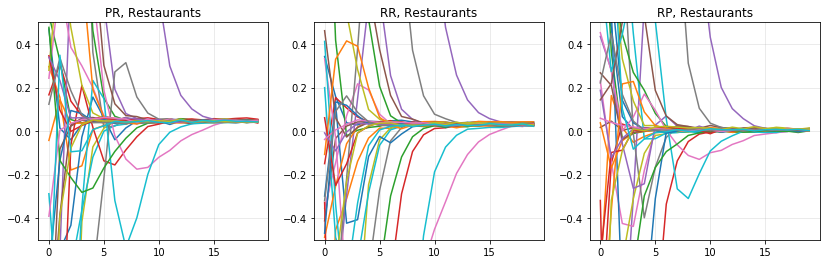

In [37]:
# check convergence over epochs
num_epochs = 20
group_idx = group2idx['Full-Service Restaurants']
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
tier_pairs = [(0, 1), (1, 1), (1, 0)]
tier_labels = ['PR', 'RR', 'RP']
for ax, (cbg_tier, poi_tier), lbl in zip(axes, tier_pairs, tier_labels):
    plot_parameter_over_epochs(main_exts, main_exts, num_epochs, device, 
                               lambda x: get_tier_pair_weight(x, cbg_tier, poi_tier, group_idx),
                               param_name=f'{lbl}, Restaurants', ax=ax, label_axes=False)
for i in range(3):
    axes[i].set_ylim(-0.5, 0.5)

PR, General Stores final val: mean=0.067, std=0.011
RR, General Stores final val: mean=0.026, std=0.006
RP, General Stores final val: mean=0.005, std=0.009


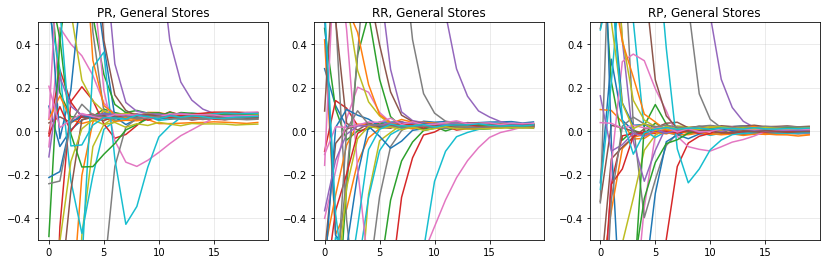

In [38]:
group_idx = group2idx['General Merchandise Stores, including Warehouse Clubs and Supercenters']
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (cbg_tier, poi_tier), lbl in zip(axes, tier_pairs, tier_labels):
    plot_parameter_over_epochs(main_exts, main_exts, num_epochs, device, 
                               lambda x: get_tier_pair_weight(x, cbg_tier, poi_tier, group_idx),
                               param_name=f'{lbl}, General Stores', ax=ax, label_axes=False)
for i in range(3):
    axes[i].set_ylim(-0.5, 0.5)

## Other model estimates

Param 1: mean=3.5061, std=0.0304
Param 2: mean=1.6374, std=0.0025


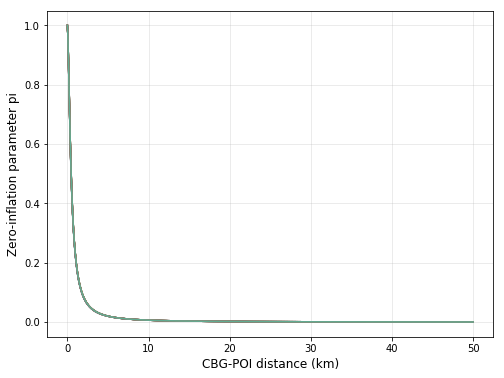

In [39]:
# how pi (ie, zero inflation mixing parameter) changes with distance
plot_distance_vs_pi(main_exts, device)

In [40]:
# other model parameters
vals = get_final_parameter_values(main_exts, device, get_lambda_dist_scaling_param,
                                  'Log distance param (in lambda)')
vals = get_final_parameter_values(main_exts, device, get_pop_scaling_param,
                                  'Log device count param')
vals = get_final_parameter_values(main_exts, device, lambda x: get_poi_weights(x)[dset.num_subcat_classes],
                                  'POI area param')

Log distance param (in lambda): mean=0.036, std=0.010
Log device count param: mean=0.058, std=0.002
POI area param: mean=0.480, std=0.075


In [41]:
dset.cbg_attrs.describe()

,percent_under_25,percent_25_to_44,percent_45_to_64,percent_65_and_over,percent_white,percent_black,percent_asian,percent_hispanic,median_household_income
count,22972.000000,22972.000000,22972.000000,22972.000000,22972.000000,22972.000000,22972.000000,22972.000000,22972.000000
mean,0.322059,0.275040,0.339358,0.142044,0.630691,0.057532,0.129327,0.365156,0.276437
std,0.110635,0.096058,0.105782,0.097247,0.225719,0.103409,0.162572,0.278869,0.155494
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253261,0.216840,0.267922,0.078439,0.473292,0.000000,0.016689,0.127931,0.164939
50%,0.321161,0.270781,0.334686,0.122597,0.666561,0.018338,0.068956,0.289893,0.243496
75%,0.390415,0.323936,0.406044,0.182338,0.814554,0.066527,0.172809,0.571604,0.350843
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


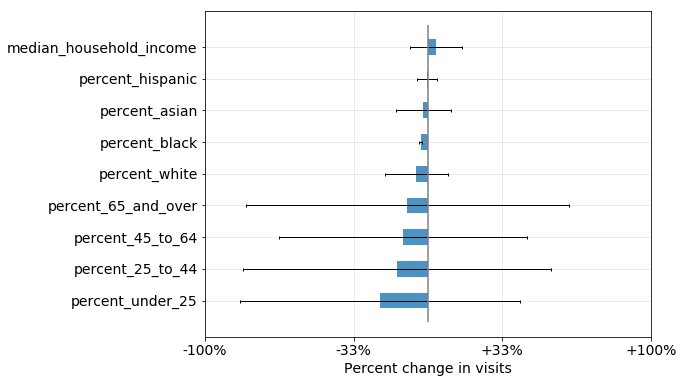

In [42]:
df = plot_cbg_weights_over_multiple_experiments(main_exts, device, dset.cbg_attrs.columns, bar_height=5, 
                                                xlim=(-1, 1))